#### LICENSE
These notes are released under the 
"Creative Commons Attribution-ShareAlike 4.0 International" license. 
See the **human-readable version** [here](https://creativecommons.org/licenses/by-sa/4.0/)
and the **real thing** [here](https://creativecommons.org/licenses/by-sa/4.0/legalcode). 

# Simple examples of robust estimators for linear regression

### Simple linear regression
We will use the `phosphor` data. 
Details can be found using `help(phosphor, package='RobStatTM')`. 
The response is `plant` and, 
to simplify the example, we select only one explanatory variable,
`organic`. In order to illustrate the impact of outliers, we will 
change the position of the real outlier (from the 
right end of the plot, to the left).


Attaching package: 'RobStatTM'


The following object is masked from 'package:datasets':

    stackloss




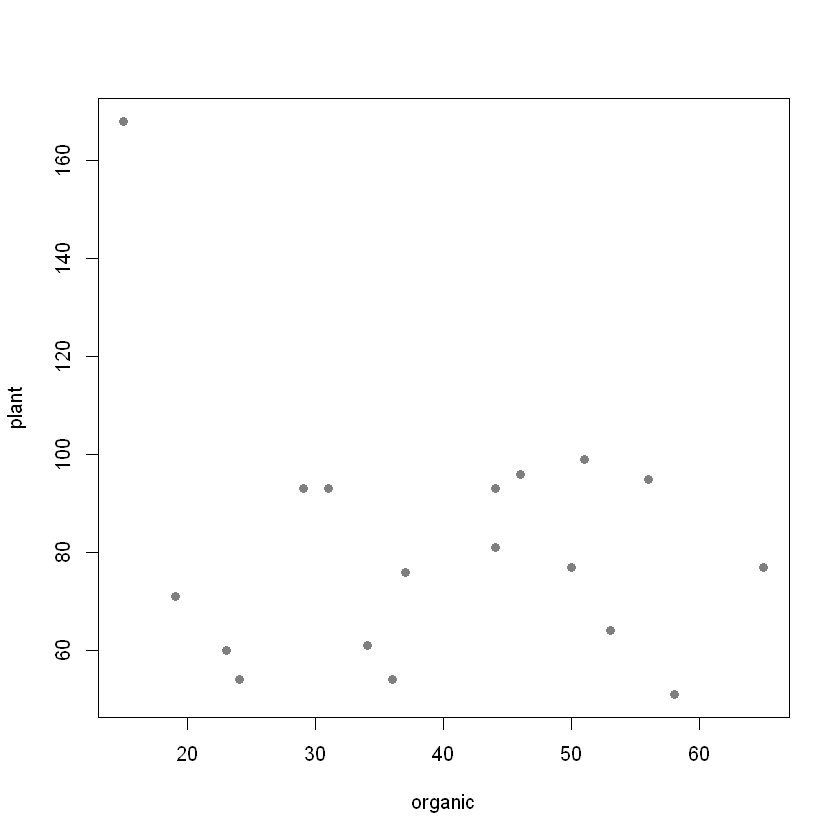

In [1]:
data(phosphor, package='robustbase')
library(RobStatTM)
# artificially change the location of the outlier 
# for illustration purposes
phosphor[17, 'organic'] <- 15
plot(plant ~ organic, data=phosphor, pch=19, col='gray50')

We now plot the MM-regression estimator, in red, and the least squares
one, in blue:

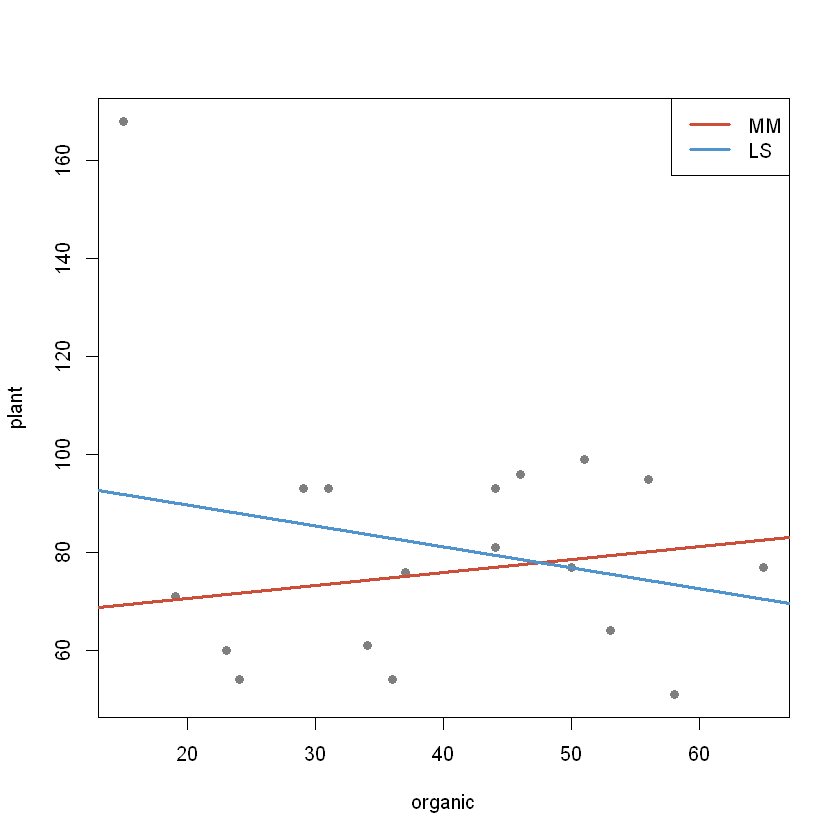

In [2]:
MMfit <- lmrobdetMM(plant ~ organic, data=phosphor)
LSfit <- lm(plant ~ organic, data=phosphor)
plot(plant ~ organic, data=phosphor, pch=19, col='gray50')
abline(MMfit, lwd=3, col='tomato3')
abline(LSfit, lwd=3, col='steelblue3')
legend('topright', lwd=3, lty=1, col=c('tomato3', 'steelblue3'), 
       legend=c('MM', 'LS'))

We look at the estimated regression coefficients:

In [3]:
cbind(MM=coef(MMfit), LS=coef(LSfit))

,MM,LS
(Intercept),65.3456071,98.2718059
organic,0.2632939,-0.4278217


Furthermore, compare these estimators with the LS one without 
the outlier:

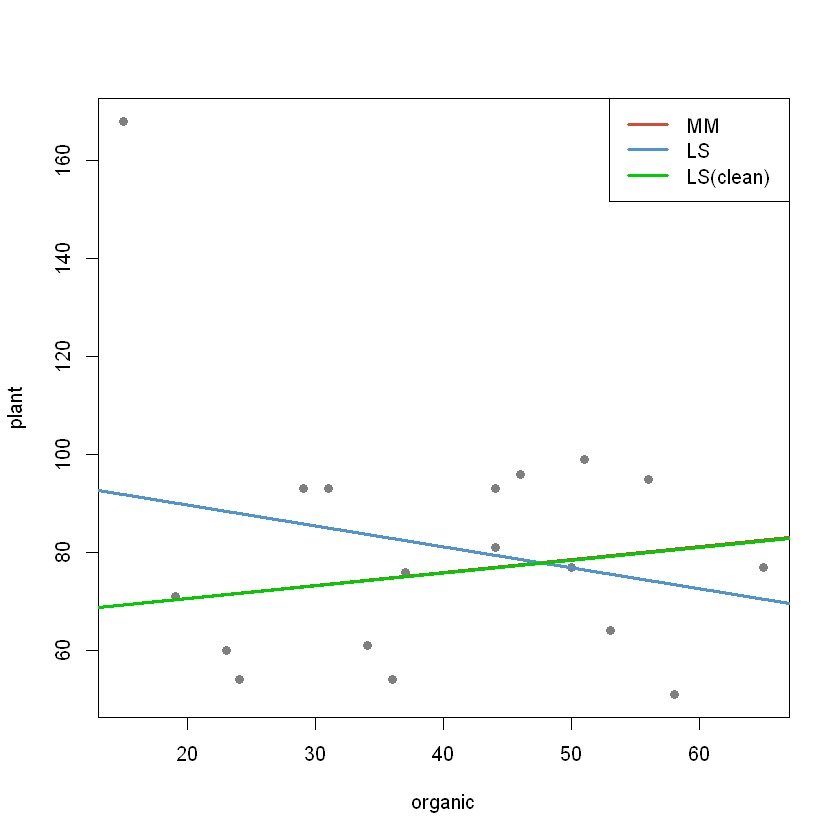

In [4]:
plot(plant ~ organic, data=phosphor, pch=19, col='gray50')
abline(MMfit, lwd=3, col='tomato3')
abline(LSfit, lwd=3, col='steelblue3')
LSclean <- lm(plant ~ organic, data=phosphor, subset=-17)
abline(LSclean, lwd=3, col='green3')
legend('topright', lwd=3, lty=1, col=c('tomato3', 'steelblue3', 'green3'), 
       legend=c('MM', 'LS', 'LS(clean)'))

We look at the estimated regression coefficients:

In [5]:
cbind(MM=coef(MMfit), LS=coef(LSfit), LSclean=coef(LSclean))

,MM,LS,LSclean
(Intercept),65.3456071,98.2718059,65.3783806
organic,0.2632939,-0.4278217,0.2622393


Note that the MM-estimator is indistinguishable from the 
LS estimator computed on the clean data. This is the desired
result of using an efficient and robust estimator. 


#### A synthetic toy example (diagnostics and estimation)

This example will show that

- Outliers can be severerly damaging without being "obviously" deviating;
- Quantile (L1) regression estimators offer limited protection against atypical observations;
- Classical diagnostic tools may not work as advertised.

Our example contains $$n = 200$$ observations with $$p = 6$$
explanatory variables. The regression model is $$Y = 
V1 + 2*V2 + V3 + V4 + V5 + \varepsilon$$, where 
$$\varepsilon$$ follows a $$N(0, 1.7)$$ distribution. 
Hence, the true vector of regression 
coefficients is `(1, 2, 1, 1, 1, 0)` and the true intercept is 
zero. The explanatory variables are all independent standard
normal random variables. I used the following code 
to generate the data

In [6]:
n <- 200
p <- 6
set.seed(123)
x0 <- as.data.frame(matrix(rnorm(n*p), n, p))
x0$y <- with(x0, V1 + 2*V2 + V3 + V4 + V5 + rnorm(n, sd=1.7))

We now replace the last 20 observations
with outliers (for a total proportion of atypical observations of 20/200 = 10%).

In [7]:
eps <- .1
n1 <- ceiling(n*(1-eps))
x0[n1:n, 1:p] <- matrix(rnorm((n-n1+1)*p, mean=+1.85, sd=.8))
x0$y[n1:n] <- rnorm(n-n1+1, mean=-7, sd=1.7)

These atypical observations cannot be seen easily in 
a pairwise plot, specially if one does not know 
in advance that they are present:

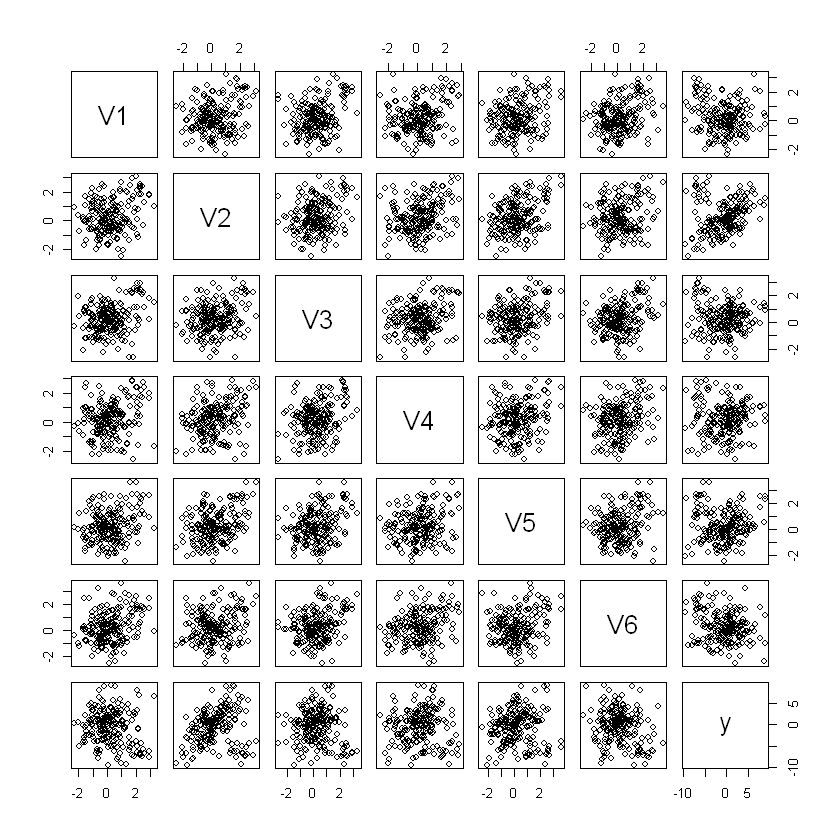

In [8]:
pairs(x0)

Standard diagnostic plots do not flag anything of 
importance either:

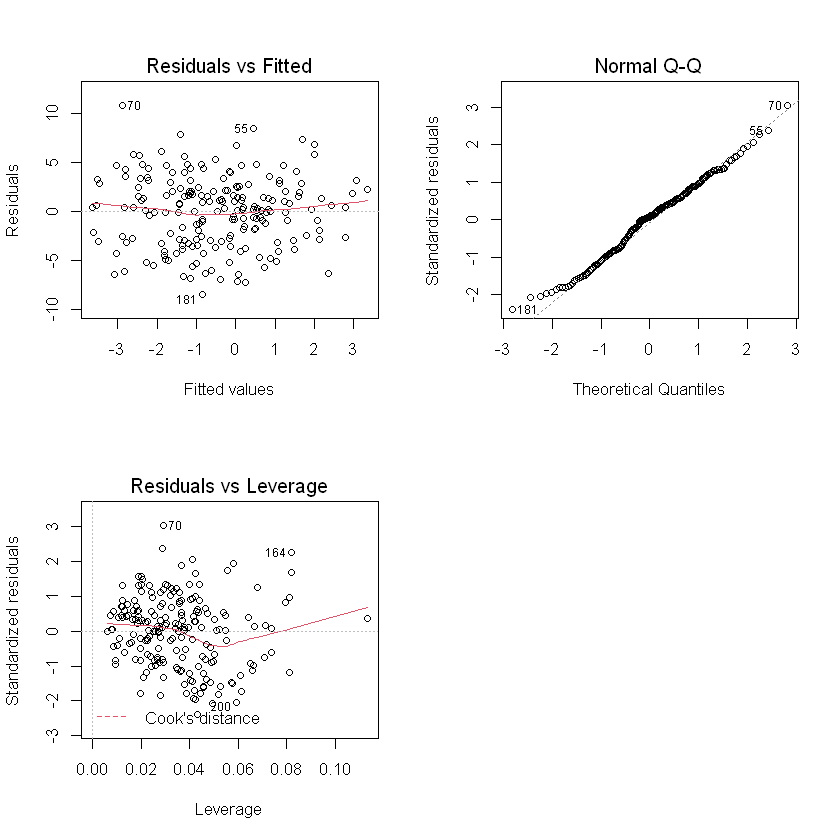

In [9]:
m0 <- lm(y~., data=x0)
par(mfrow=c(2,2))
plot(m0, which=c(1, 2, 5))
par(mfrow=c(1,1))

Note that all the Cook distances are below 0.15, 
for example. 
However, the estimated regression coefficients are
very different from the true ones
(1, 2, 1, 1, 1, 0)

In [10]:
cbind(LS=coef(m0), Truth=c(0,1, 2, 1, 1, 1, 0))

,LS,Truth
(Intercept),-0.44554207,0
V1,-0.51498293,1
V2,1.05890198,2
V3,-0.25125929,1
V4,0.06335662,1
V5,0.07413599,1
V6,-0.77788104,0


We now compare the estimated regression 
coefficients obtained with 2 other methods:
an MM-estimator,
and the L1-estimator (which is a quantile
regression estimator). We will later see in
the course that these estimators 
have different robustness properties.

In [11]:
library(RobStatTM)
myc <- lmrobdet.control(family='bisquare', efficiency=.85)
m1 <- lmrobdetMM(y~., data=x0, control=myc)
m3 <- quantreg::rq(y~., data=x0)
cbind(Truth=c(0, 1, 2, 1, 1, 1, 0),
      LS=coef(m0), L1=coef(m3), MM=coef(m1))

,Truth,LS,L1,MM
(Intercept),0,-0.44554207,0.050557638,-0.1517327
V1,1,-0.51498293,-0.008095437,0.9173941
V2,2,1.05890198,1.291600765,2.2397068
V3,1,-0.25125929,0.305027876,1.0844115
V4,1,0.06335662,0.396052030,1.0856345
V5,1,0.07413599,0.445126101,1.2830538
V6,0,-0.77788104,-0.585828949,0.3272069


We can also compare the diagnostic plots obtained with
the robust estimator, where the outliers are
clearly visible.

recomputing robust Mahalanobis distances

saving the robust distances 'MD' as part of 'm1'



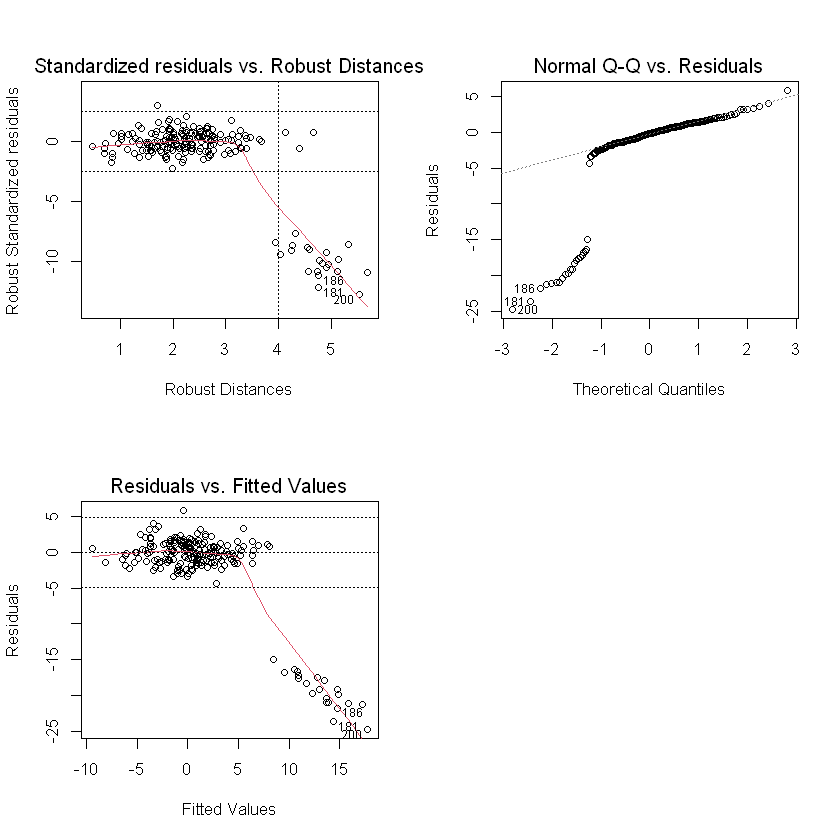

In [12]:
par(mfrow=c(2,2))
plot(m1, which=c(1, 2, 4))
par(mfrow=c(1,1))

Add now the LS estimator computed on the "clean" data:

In [13]:
m0.cl <- lm(y~., data=x0, subset = -(n1:n) )
cbind(Truth=c(0, 1, 2, 1, 1, 1, 0),
      LS=coef(m0), L1=coef(m3),  
      MM=coef(m1), LSclean = coef(m0.cl))

,Truth,LS,L1,MM,LSclean
(Intercept),0,-0.44554207,0.050557638,-0.1517327,-0.1230974
V1,1,-0.51498293,-0.008095437,0.9173941,0.9258029
V2,2,1.05890198,1.291600765,2.2397068,2.2469820
V3,1,-0.25125929,0.305027876,1.0844115,1.0472022
V4,1,0.06335662,0.396052030,1.0856345,1.0490738
V5,1,0.07413599,0.445126101,1.2830538,1.2444115
V6,0,-0.77788104,-0.585828949,0.3272069,0.3117131
